In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [41]:
# Run model prep notebook
%run Model_prep.ipynb

In [42]:
# Read in dataset
# train = pd.read_csv('train_synthetic.csv')
train = pd.read_csv('train_sample_synthetic.csv')
# train = pd.read_csv('train_sample.csv') # TODO: Synthetic data is outdated
train.head()

,gameId,playId,nflId,frameId,x,y,unitDir,unitO,force,home,...,defendersInTheBox,offenseFormation,absoluteYardlineNumber,timeSinceStart,surface,inside_outside,presnapDefScoreDiff,weight,position,gamePlayId
0,2.022091e+09,56.0,38577.0,6.0,41.89,28.74,87.71,79.47,288.200000,1,...,6.0,SHOTGUN,85,0,turf,inside,0,242,ILB,2022090800.056.0
1,2.022091e+09,56.0,41239.0,6.0,27.85,29.96,247.65,276.16,364.000000,1,...,6.0,SHOTGUN,85,0,turf,inside,0,280,DT,2022090800.056.0
2,2.022091e+09,56.0,42816.0,6.0,49.38,7.66,8.33,61.57,346.254545,1,...,6.0,SHOTGUN,85,0,turf,inside,0,184,CB,2022090800.056.0
3,2.022091e+09,56.0,43294.0,6.0,41.85,37.85,268.50,230.96,116.290909,1,...,6.0,SHOTGUN,85,0,turf,inside,0,208,CB,2022090800.056.0
4,2.022091e+09,56.0,43298.0,6.0,27.89,33.14,293.53,249.12,241.090909,1,...,6.0,SHOTGUN,85,0,turf,inside,0,240,DE,2022090800.056.0


In [43]:
# Fill columns with na to 0 TODO: TEMPORARY until fix dataset
train.isna().sum()

train['tackle_efficiency_ingame'].fillna(0, inplace=True)
train['tackle_rating_ingame'].fillna(0, inplace=True)

train.isna().sum()

gameId                 0
playId                 0
nflId                  0
frameId                0
x                      0
                      ..
inside_outside         0
presnapDefScoreDiff    0
weight                 0
position               0
gamePlayId             0
Length: 79, dtype: int64

In [44]:
# Adjust gamePlayId to account for synthetic data
duplicates_mask = train.duplicated(subset=['gamePlayId','frameId','nflId'], keep='first')
train.loc[duplicates_mask, 'gamePlayId'] += '.1'

In [45]:
# Get x, y, mask, and id mapping variables from data tensor function
target_variable = 'tackle_binary_single'
x, y, mask, id_data = data_tensors_cnn_4d(train, target_variable)

In [46]:
# Print shapes of variables
print(x.shape)
print(y.shape)
print(mask.shape)
print(id_data.shape)

torch.Size([2618, 140, 11, 87])
torch.Size([2618, 140, 11])
torch.Size([2618, 140, 11])
(4031720, 3)


In [47]:
# Split the data for modeling
split_ratio = 0.8

total_plays = x.size(0)
num_train_plays = int(total_plays * split_ratio)

# Split tensors into training and testing set
x_train = x[:num_train_plays]
y_train = y[:num_train_plays]
mask_train = mask[:num_train_plays]
id_data_train = id_data[:num_train_plays]

x_test = x[num_train_plays:]
y_test = y[num_train_plays:]
mask_test = mask[num_train_plays:]
id_data_test = id_data[num_train_plays:]

# Print shapes
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("mask_train shape: ", mask_train.shape)
print("id_data_train shape: ", id_data_train.shape)

print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

print("number of tackles in y_test: ", y_test.sum())

x_train shape:  torch.Size([2094, 140, 11, 87])
y_train shape:  torch.Size([2094, 140, 11])
mask_train shape:  torch.Size([2094, 140, 11])
id_data_train shape:  (2094, 3)
x_test shape:  torch.Size([524, 140, 11, 87])
y_test shape:  torch.Size([524, 140, 11])
number of tackles in y_test:  tensor(652)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 138, 9, 32)        25088     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 69, 4, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 67, 2, 64)         18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 33, 1, 64)         0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 2112)              0         
                                                                 
 dense_3 (Dense)             (None, 1540)             

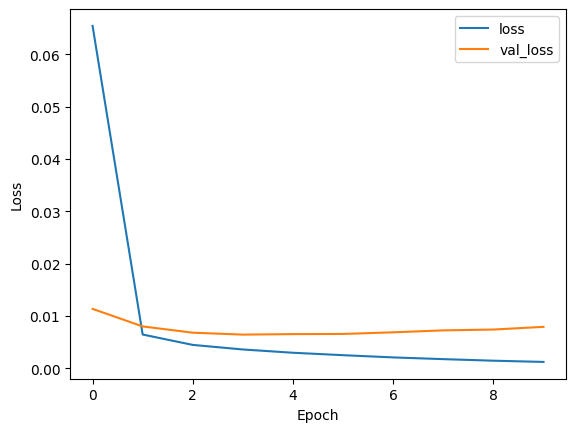

17/17 [==============================] - 0s 10ms/step
Prediction for the first example: [1.9804574e-07 4.6009237e-08 5.6253658e-08 ... 4.0127063e-08 9.1667637e-08
 6.7689662e-08]
Prediction for example 1: [1.9804574e-07 4.6009237e-08 5.6253658e-08 ... 4.0127063e-08 9.1667637e-08
 6.7689662e-08]
Prediction for example 2: [1.9804574e-07 4.6009237e-08 5.6253658e-08 ... 4.0127063e-08 9.1667637e-08
 6.7689662e-08]
Prediction for example 3: [1.6499488e-08 2.0108647e-08 1.6276685e-08 ... 3.4194546e-08 6.5783068e-09
 3.6739991e-09]
Prediction for example 4: [1.6499488e-08 2.0108647e-08 1.6276685e-08 ... 3.4194546e-08 6.5783068e-09
 3.6739991e-09]
Prediction for example 5: [3.6169684e-10 6.0010374e-10 1.3220962e-09 ... 5.7315872e-09 7.6486664e-11
 1.0597775e-10]
Prediction for example 6: [3.6169684e-10 6.0010374e-10 1.3220962e-09 ... 5.7315872e-09 7.6486664e-11
 1.0597775e-10]
Prediction for example 7: [2.1527233e-12 3.4963105e-11 2.7234213e-12 ... 3.5656495e-11 4.4213834e-12
 4.6436587e-11]
Pr

In [48]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Convert PyTorch tensors to NumPy arrays
x_train_np = x_train.numpy()
y_train_np = y_train.numpy()
x_test_np = x_test.numpy()
y_test_np = y_test.numpy()

# Convert NumPy arrays to TensorFlow tensors
x_train_tf = tf.convert_to_tensor(x_train_np, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train_np, dtype=tf.float32)
x_test_tf = tf.convert_to_tensor(x_test_np, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test_np, dtype=tf.float32)

# Reshape TensorFlow tensors
y_train_tf = tf.reshape(y_train_tf, (y_train.shape[0], -1))
y_test_tf = tf.reshape(y_test_tf, (y_test.shape[0], -1))

def create_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(input_shape)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(140 * 11, activation='softmax'))  # Adjust the number of units todo: change sigmoid to softmax
    return model

# Assuming input shape (frames, players, features)
input_shape = (x_train_tf.shape[1], x_train_tf.shape[2], x_train_tf.shape[3])
model = create_cnn_model(input_shape)

# Print model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # NEED TO CHANGE TO LOG LOSS

# Train the model
batch_size = 32
epochs = 10

history = model.fit(x_train_tf, y_train_tf, validation_data=(x_test_tf, y_test_tf), batch_size=batch_size, epochs=epochs)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test_tf, y_test_tf)
print(f'Test accuracy: {test_acc}')

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')  # Use 'loss' instead of 'accuracy' for log loss
plt.plot(history.history['val_loss'], label='val_loss')  # Use 'val_loss' instead of 'val_accuracy'
plt.xlabel('Epoch')
plt.ylabel('Loss')  # Change the ylabel to 'Loss'
plt.legend(loc='upper right')  # Change the legend location
plt.show()

# Predictions on the test set
predictions = model.predict(x_test_tf)

# The 'predictions' variable now contains the model's output for each input in the test set.
# You can inspect individual predictions as follows:

# For example, to look at the prediction for the first example in the test set:
print(f"Prediction for the first example: {predictions[0]}")

# You can iterate through the predictions for all examples:
for i, pred in enumerate(predictions):
    print(f"Prediction for example {i + 1}: {pred}")

# Alternatively, if you want to see the predicted class labels (assuming binary classification):
predicted_classes = (predictions > 0.5).astype(int)
print(f"Predicted classes: {predicted_classes}")

In [49]:
unique, counts = np.unique(predicted_classes, return_counts=True)
dict(zip(unique, counts))

{0: 806802, 1: 158}

(array([30., 10., 18., 14., 18., 12., 20.,  8., 12., 16.]),
 array([0.50714415, 0.55633414, 0.60552412, 0.65471405, 0.70390403,
        0.75309402, 0.802284  , 0.85147399, 0.90066391, 0.9498539 ,
        0.99904388]),
 <BarContainer object of 10 artists>)

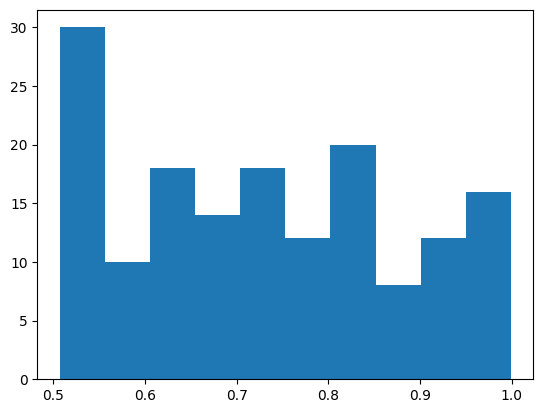

In [50]:
# Flatten to get to 1d
predictions = predictions.flatten()
pd.DataFrame(predictions)
# Non flattened shape - 524 plays - 1540 columns are 140 frames * 11 players - each row represents an entire play
plt.hist(predictions[predictions > 0.5]) #, bins = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])

# Run CNN with extending DV

In [51]:
# Read in dataset
# train = pd.read_csv('train_synthetic.csv')
train_df = pd.read_csv('train_sample_synthetic.csv')
# train_df = pd.read_csv('train_sample.csv') # TODO: Synthetic data is outdated
train_df.head()

,gameId,playId,nflId,frameId,x,y,unitDir,unitO,force,home,...,defendersInTheBox,offenseFormation,absoluteYardlineNumber,timeSinceStart,surface,inside_outside,presnapDefScoreDiff,weight,position,gamePlayId
0,2.022091e+09,56.0,38577.0,6.0,41.89,28.74,87.71,79.47,288.200000,1,...,6.0,SHOTGUN,85,0,turf,inside,0,242,ILB,2022090800.056.0
1,2.022091e+09,56.0,41239.0,6.0,27.85,29.96,247.65,276.16,364.000000,1,...,6.0,SHOTGUN,85,0,turf,inside,0,280,DT,2022090800.056.0
2,2.022091e+09,56.0,42816.0,6.0,49.38,7.66,8.33,61.57,346.254545,1,...,6.0,SHOTGUN,85,0,turf,inside,0,184,CB,2022090800.056.0
3,2.022091e+09,56.0,43294.0,6.0,41.85,37.85,268.50,230.96,116.290909,1,...,6.0,SHOTGUN,85,0,turf,inside,0,208,CB,2022090800.056.0
4,2.022091e+09,56.0,43298.0,6.0,27.89,33.14,293.53,249.12,241.090909,1,...,6.0,SHOTGUN,85,0,turf,inside,0,240,DE,2022090800.056.0


In [52]:
# Fill columns with na to 0 TODO: TEMPORARY until fix dataset
train_df.isna().sum()

train_df['tackle_efficiency_ingame'].fillna(0, inplace=True)
train_df['tackle_rating_ingame'].fillna(0, inplace=True)

train_df.isna().sum()

gameId                 0
playId                 0
nflId                  0
frameId                0
x                      0
                      ..
inside_outside         0
presnapDefScoreDiff    0
weight                 0
position               0
gamePlayId             0
Length: 79, dtype: int64

In [53]:
# Adjust gamePlayId to account for synthetic data
duplicates_mask = train_df.duplicated(subset=['gamePlayId','frameId','nflId'], keep='first')
train_df.loc[duplicates_mask, 'gamePlayId'] += '.1'

In [54]:
extend_dv = 'tackle_binary_single'

# Identify rows where tackle_binary_single is equal to 1
tackle_rows = train_df[train_df['tackle_binary_single'] == 1]

# Create a list to store the indices of rows to be updated
rows_to_update = []

# Get identifiers for each row with tackle_binary_single = 1 
for _, row in tackle_rows.iterrows():
    gamePlayId = row['gamePlayId']
    nflId = row['nflId']
    frameId = row['frameId']

    # Identify the rows to be updated based on gamePlayId, nflId, and frame
    rows_to_update.extend(
        train_df[
            (train_df['gamePlayId'] == gamePlayId) &
            (train_df['nflId'] == nflId) &
            ((train_df['frameId'] >= frameId - 2) & (train_df['frameId'] <= frameId + 2))
        ].index
    )

# Update the values in the identified rows
train_df.loc[rows_to_update, 'tackle_binary_single'] = 1

In [55]:
# Get x, y, mask, and id mapping variables from data tensor function
target_variable = 'tackle_binary_single'
x, y, mask, id_data = data_tensors_cnn_4d(train_df, target_variable)

In [56]:
# Print shapes of variables
print(x.shape)
print(y.shape)
print(mask.shape)
print(id_data.shape)

torch.Size([2618, 140, 11, 87])
torch.Size([2618, 140, 11])
torch.Size([2618, 140, 11])
(4031720, 3)


In [57]:
# Split the data for modeling
split_ratio = 0.8

total_plays = x.size(0)
num_train_plays = int(total_plays * split_ratio)

# Split tensors into training and testing set
x_train = x[:num_train_plays]
y_train = y[:num_train_plays]
mask_train = mask[:num_train_plays]
id_data_train = id_data[:num_train_plays]

x_test = x[num_train_plays:]
y_test = y[num_train_plays:]
mask_test = mask[num_train_plays:]
id_data_test = id_data[num_train_plays:]

# Print shapes
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("mask_train shape: ", mask_train.shape)
print("id_data_train shape: ", id_data_train.shape)

print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

print("Number of tackles in y_test: ", y_test.sum())

x_train shape:  torch.Size([2094, 140, 11, 87])
y_train shape:  torch.Size([2094, 140, 11])
mask_train shape:  torch.Size([2094, 140, 11])
id_data_train shape:  (2094, 3)
x_test shape:  torch.Size([524, 140, 11, 87])
y_test shape:  torch.Size([524, 140, 11])
Number of tackles in y_test:  tensor(1954)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 138, 9, 32)        25088     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 69, 4, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 67, 2, 64)         18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 33, 1, 64)         0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 2112)              0         
                                                                 
 dense_4 (Dense)             (None, 1540)             

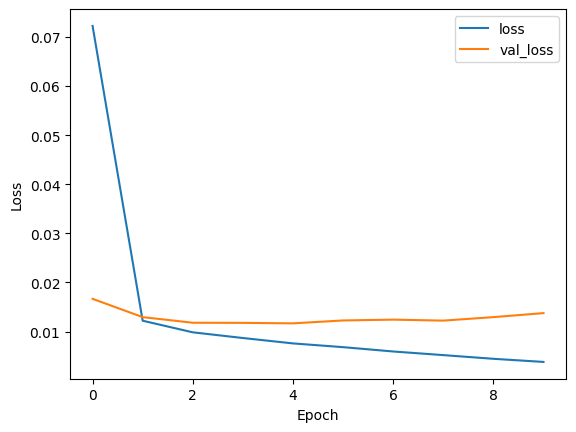

17/17 [==============================] - 0s 11ms/step
Prediction for the first example: [1.3059672e-08 1.4905739e-08 1.6295520e-08 ... 6.7976714e-08 3.2589313e-08
 7.7342497e-09]
Prediction for example 1: [1.3059672e-08 1.4905739e-08 1.6295520e-08 ... 6.7976714e-08 3.2589313e-08
 7.7342497e-09]
Prediction for example 2: [1.3059672e-08 1.4905739e-08 1.6295520e-08 ... 6.7976714e-08 3.2589313e-08
 7.7342497e-09]
Prediction for example 3: [8.5447610e-08 2.0497922e-08 4.4325493e-08 ... 4.4277751e-08 1.3986723e-07
 2.9266532e-08]
Prediction for example 4: [8.5447610e-08 2.0497922e-08 4.4325493e-08 ... 4.4277751e-08 1.3986723e-07
 2.9266532e-08]
Prediction for example 5: [6.6159700e-09 2.8170008e-10 6.1779321e-10 ... 1.3914404e-09 1.6232719e-09
 2.1427914e-10]
Prediction for example 6: [6.6159700e-09 2.8170008e-10 6.1779321e-10 ... 1.3914404e-09 1.6232719e-09
 2.1427914e-10]
Prediction for example 7: [1.4909039e-13 2.5527491e-13 1.9789266e-14 ... 7.1462112e-13 4.6360116e-13
 1.0379876e-13]
Pr

In [58]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Convert PyTorch tensors to NumPy arrays
x_train_np = x_train.numpy()
y_train_np = y_train.numpy()
x_test_np = x_test.numpy()
y_test_np = y_test.numpy()

# Convert NumPy arrays to TensorFlow tensors
x_train_tf = tf.convert_to_tensor(x_train_np, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train_np, dtype=tf.float32)
x_test_tf = tf.convert_to_tensor(x_test_np, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test_np, dtype=tf.float32)

# Reshape TensorFlow tensors
y_train_tf = tf.reshape(y_train_tf, (y_train.shape[0], -1))
y_test_tf = tf.reshape(y_test_tf, (y_test.shape[0], -1))

def create_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(input_shape)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(140 * 11, activation='softmax'))  # Adjust the number of units todo: change sigmoid to softmax
    return model

# Assuming input shape (frames, players, features)
input_shape = (x_train_tf.shape[1], x_train_tf.shape[2], x_train_tf.shape[3])
model = create_cnn_model(input_shape)

# Print model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # NEED TO CHANGE TO LOG LOSS

# Train the model
batch_size = 32
epochs = 10

history = model.fit(x_train_tf, y_train_tf, validation_data=(x_test_tf, y_test_tf), batch_size=batch_size, epochs=epochs)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test_tf, y_test_tf)
print(f'Test accuracy: {test_acc}')

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')  # Use 'loss' instead of 'accuracy' for log loss
plt.plot(history.history['val_loss'], label='val_loss')  # Use 'val_loss' instead of 'val_accuracy'
plt.xlabel('Epoch')
plt.ylabel('Loss')  # Change the ylabel to 'Loss'
plt.legend(loc='upper right')  # Change the legend location
plt.show()

# Predictions on the test set
predictions = model.predict(x_test_tf)

# The 'predictions' variable now contains the model's output for each input in the test set.
# You can inspect individual predictions as follows:

# For example, to look at the prediction for the first example in the test set:
print(f"Prediction for the first example: {predictions[0]}")

# You can iterate through the predictions for all examples:
for i, pred in enumerate(predictions):
    print(f"Prediction for example {i + 1}: {pred}")

# Alternatively, if you want to see the predicted class labels (assuming binary classification):
predicted_classes = (predictions > 0.5).astype(int)
print(f"Predicted classes: {predicted_classes}")

In [59]:
unique, counts = np.unique(predicted_classes, return_counts=True)
dict(zip(unique, counts))

{0: 806882, 1: 78}

(array([14., 18., 14.,  0., 12., 10.,  2.,  2.,  4.,  2.]),
 array([0.50527561, 0.55111855, 0.59696156, 0.6428045 , 0.68864745,
        0.73449039, 0.7803334 , 0.82617635, 0.87201929, 0.9178623 ,
        0.96370524]),
 <BarContainer object of 10 artists>)

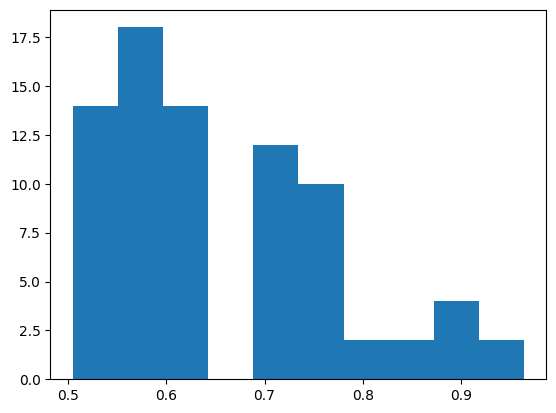

In [60]:
# Flatten to get to 1d
predictions = predictions.flatten()
pd.DataFrame(predictions)
# Non flattened shape - 524 plays - 1540 columns are 140 frames * 11 players - each row represents an entire play
plt.hist(predictions[predictions > 0.5]) #, bins = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])